In [57]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [34]:
N= 200
np.random.seed(123)
beta_vec = np.array([2,4,-2])
x1 = np.random.normal(loc=8.0, scale=2, size=N)
x2 = np.random.normal(loc=2.0, scale=1, size=N)
x3 = 2 - 2*x1
e = np.random.normal(loc=0, scale=1, size=N)

y1 = np.dot(sm.add_constant(np.column_stack((x1, x2))), beta_vec) + e
y2 = np.dot(sm.add_constant(np.column_stack((x1, x3))), beta_vec) + e

In [37]:
x_mat_1 = sm.add_constant(np.column_stack((x1, x2)))
np.linalg.matrix_rank(x_mat_1)

3

In [38]:
x_mat_2 = sm.add_constant(np.column_stack((x1, x3)))
np.linalg.matrix_rank(x_mat_2)

2

In [39]:
print(np.linalg.inv(np.dot(np.transpose(x_mat_2), x_mat_2)))

[[-2.44335917e+11  2.44335917e+11  1.22167959e+11]
 [ 2.44335917e+11 -2.44335917e+11 -1.22167959e+11]
 [ 1.22167959e+11 -1.22167959e+11 -6.10839793e+10]]


In [33]:
print(np.linalg.det(np.dot(np.transpose(x_mat_2), x_mat_2)))

-2.90094837884564e-06


In [40]:
x_mat_2_small = sm.add_constant(x1)
np.dot(np.linalg.inv(np.dot(np.transpose(x_mat_2_small), x_mat_2_small)), np.dot(np.transpose(x_mat_2_small), y2))

array([-1.92052035,  7.99857564])

In [52]:
import statsmodels.formula.api as smf
import pandas as pd

dt1 = pd.DataFrame(np.column_stack([y1, x1, x2]), columns=["y1", "x1", "x2"])
dt1 = pd.DataFrame(np.column_stack([y1, x1, x3]), columns=["y1", "x1", "x3"])
ols_formula = "y1~ x1 + x2"
mdl_1 = smf.ols(formula=ols_formula, data=dt1).fit()
mdl_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0215,0.320,6.321,0.000,1.391,2.652
x1,3.9985,0.034,116.274,0.000,3.931,4.066
x2,-1.9689,0.078,-25.185,0.000,-2.123,-1.815


In [53]:
ols_formula = "y1~ x1 + x3"
mdl_2 = smf.ols(formula=ols_formula, data=dt1).fit()
mdl_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.8601,0.294,2.926,0.004,0.280,1.440
x1,1.4866,0.222,6.707,0.000,1.050,1.924
x3,-1.2531,0.145,-8.652,0.000,-1.539,-0.967


Python does not adjust for multicollinearity by removing collinear variables. On the other hand, it calculates a generalized inverse in order to estimate the OLS parameters.

Fortunately, if we look at the out `summary()` - there is a warning regarding possible multicollinearity, which we can extract seperately:

In [77]:
mdl_1.summary().extra_txt

'Notes:\n[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.'

In [78]:
mdl_2.summary().extra_txt

'Notes:\n[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.\n[2] The smallest eigenvalue is 1.25e-30. This might indicate that there are\nstrong multicollinearity problems or that the design matrix is singular.'

### Consequences of Multicollinearity
Consequently multicollinearity results in multiple difficulties:

* That the standard errors of the affected coefficients tend to be large
* Small changes in the input data can lead to large changes in the model even resulting in chanves of sign of paramets estimates.
* R^2 may be strangely large, which should be concerning when a model contains insignificant variables and variable with incorrect signs
* The usual interpretation of a unit increase in $X_{j,i}$ effect on Y, holding all else constant does not hold if the explanatory variables are correlated.
* In some sense, the collinear variables contain, at least partially, the same information about the depend variable. A consequence of such data redundancy is overfitting

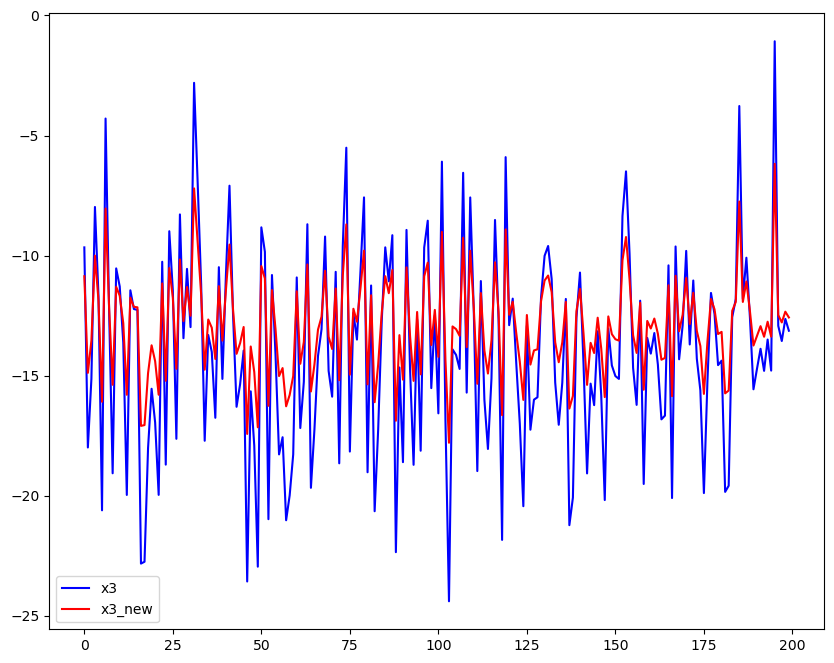

In [79]:
import matplotlib.pyplot as plt

np.random.seed(123)

x3_new = 2 - 2 * np.power(x1, 0.9) + np.random.normal(loc=-2, scale=1, size=N)
y2_new = sm.add_constant(np.column_stack([x1, x3_new])).dot(beta_vec) + e

_ = plt.figure(num=0, figsize=(10,8))
_ = plt.plot(x3, label="x3", color="blue")
_ = plt.plot(x3_new, label="x3_new", color="red")
_ = plt.legend(loc="lower left")
plt.show()

In [64]:
np.corrcoef([x3, x3_new])

array([[1.        , 0.99944538],
       [0.99944538, 1.        ]])

In [65]:
dt3 = pd.DataFrame(np.column_stack([y2_new, x1, x3_new]), 
                   columns = ["y2_new", "x1", "x3_new"])
mdl_3 = smf.ols("y2_new ~ x1 + x3_new", data = dt3)
#
print(np.round(mdl_3.fit().summary2().tables[1], 4))

            Coef.  Std.Err.       t   P>|t|  [0.025   0.975]
Intercept  2.2531    5.5268  0.4077  0.6840 -8.6463  13.1525
x1         4.0311    1.0331  3.9021  0.0001  1.9938   6.0683
x3_new    -1.9665    1.0638 -1.8486  0.0660 -4.0644   0.1313


In [66]:
np.round(mdl_3.fit().rsquared, 4)

0.9934

We see that the paramters are estimated close to the true values, even when $X_1$ and $X_3$ are related . On the other hand, the coefficients of $X_3$ is not statistically significantly different from zero.

In [68]:
mdl_4 = smf.ols("y2_new ~ x1 + x3_new + np.power(x3_new, 2)", data = dt3)
np.round(mdl_4.fit().summary2().tables[1], 4)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,7.1324,32.1346,0.2220,0.8246,-56.2416,70.5064
x1,5.4225,9.0857,0.5968,0.5513,-12.4958,23.3407
x3_new,-0.9443,6.7169,-0.1406,0.8883,-14.1910,12.3025
"np.power(x3_new, 2)",-0.0161,0.1045,-0.1541,0.8777,-0.2221,0.1899


Suddenly not only did all of our coefficients become insignificant, some of them even changed sign, while others significantly decreased. Furthermore, from this model, we cannot say which variables may be collinear or even if there may be a collinearity problem.

What makes matters worse, is the R^2 and the $R^2_{adj}$ of this model is very large

In [71]:
np.round(mdl_4.fit().rsquared, 4)

0.9934

In [73]:
np.round(mdl_4.fit().rsquared_adj, 4)

0.9933

If we do the same on the model without multicolliearity,:

In [74]:
np.round(smf.ols("y1 ~ x1 + x2", data = dt1).fit().summary2().tables[1], 4)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,2.0215,0.3198,6.3212,0.0,1.3909,2.6522
x1,3.9985,0.0344,116.2739,0.0,3.9307,4.0663
x2,-1.9689,0.0782,-25.1852,0.0,-2.1231,-1.8147


In [75]:
np.round(smf.ols("y1 ~ x1 + x2 + I(x2**2)", data = dt1).fit().summary2().tables[1], 4)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,2.0687,0.3746,5.5222,0.0000,1.3299,2.8075
x1,3.9983,0.0345,115.9761,0.0000,3.9304,4.0663
x2,-2.0282,0.2558,-7.9289,0.0000,-2.5326,-1.5237
I(x2 ** 2),0.0149,0.0612,0.2435,0.8079,-0.1057,0.1355



###  Generalized Variance Inflation Factor (GVIF)

Variance inflation factors are not fully applicable to models, which include a set of regressors (i.e. indicator regressors for the same categorical variable), or polynomial regressors. This is because the correlations among these variables are induced by the model structure and therefore are artificial. Usually, we are not concerned with artificial correlations of these types - we want to identify the effects of different explanatory variables.

In [80]:
np.random.seed(123)
#
dt3["age"] = np.random.choice(["10_18", "18_26", "26_40", "other"], size = N, replace = True)
print(dt3.head())

      y2_new        x1     x3_new    age
0  48.567172  5.828739 -10.859063  26_40
1  71.212106  9.994691 -14.881628  18_26
2  62.848188  8.565957 -13.537666  26_40
3  40.641276  4.987411 -10.000399  26_40
4  53.102155  6.842799 -11.869809  10_18


In [82]:
mdl_5 = smf.ols("y2_new ~ x1 + x3_new + age", data = dt3)
np.round(mdl_5.fit().summary2().tables[1], 4)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,2.2623,5.5151,0.4102,0.6821,-8.6150,13.1396
age[T.18_26],-0.2813,0.2066,-1.3612,0.1750,-0.6888,0.1263
age[T.26_40],-0.4044,0.2032,-1.9903,0.0480,-0.8051,-0.0037
age[T.other],-0.2008,0.2027,-0.9904,0.3232,-0.6005,0.1990
x1,4.0034,1.0308,3.8836,0.0001,1.9703,6.0364
x3_new,-1.9999,1.0617,-1.8838,0.0611,-4.0938,0.0939


`x1` and `x3_new` are continuous predictors and `age` is a categorical variable presented by the indicator/dummy variables `age18_26`, `26_40` and other. In this case `10_18` is the baseline, or base group.

In [90]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(mdl_5.exog, i) for i in range(1, mdl_5.exog.shape[1])]
vif["Variable"] = mdl_5.exog_names[1:]
vif

,VIF Factor,Variable
0,1.473014,age[T.18_26]
1,1.504754,age[T.26_40]
2,1.497897,age[T.other]
3,903.350945,x1
4,903.629974,x3_new


The problem is that the `VIF` values are affected by the baseline of the categorical variable. In order to be sure of not having a VIF value above an acceptable level, it would be necessary to redo this analysis for every level of the categorical variable being the base group - i.e. we would also need to use `age18_26` as the base group and calculate the VIF’s, then do the same with `age26_40` and finally with other. This gets more complicated if we have more than one categorical variable

In [92]:
import patsy as patsy
#
age = pd.DataFrame(dt3["age"], columns= ["age"])
X1 = patsy.dmatrix("0 + C(age)", age, return_type = "dataframe")
X2 = dt3[["x1", "x3_new"]].copy() 

In [95]:
X1.head()

,C(age)[10_18],C(age)[18_26],C(age)[26_40],C(age)[other]
0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0


Note that since we do not include all of the indicator variables in the model so as to avoid the dummy variable trap, we need to drop one of the indicator variables. For simplicity, we will drop 10_18, since it was the base group for the previous model.

In [96]:
X1 = X1.drop(X1.columns[0], axis = 1)
print(X1.head())

   C(age)[18_26]  C(age)[26_40]  C(age)[other]
0            0.0            1.0            0.0
1            1.0            0.0            0.0
2            0.0            1.0            0.0
3            0.0            1.0            0.0
4            0.0            0.0            0.0


In [98]:
X2.head()

,x1,x3_new
0,5.828739,-10.859063
1,9.994691,-14.881628
2,8.565957,-13.537666
3,4.987411,-10.000399
4,6.842799,-11.869809


In [99]:
tmp_gvif = np.linalg.det(X1.corr()) * np.linalg.det(X2.corr()) / np.linalg.det(pd.concat([X1.reset_index(drop = True), X2], axis = 1).corr())
tmp_gvif = pd.DataFrame([tmp_gvif], columns = ["GVIF"])
tmp_gvif["GVIF^(1/2Df)"] = np.power(tmp_gvif["GVIF"], 1 / (2 * len(X1.columns)))
tmp_gvif

,GVIF,GVIF^(1/2Df)
0,1.025511,1.004207


In [100]:
X1 = dt3[["x1"]].copy()
X2 = patsy.dmatrix("0 + C(age)", age, return_type = "dataframe").iloc[:, 1:]
X2 = pd.concat([X2.reset_index(drop = True), dt3[["x3_new"]]], axis = 1)
#
tmp_gvif = np.linalg.det(X1.corr()) * np.linalg.det(X2.corr()) / np.linalg.det(pd.concat([X1.reset_index(drop = True), X2], axis = 1).corr())
tmp_gvif = pd.DataFrame([tmp_gvif], columns = ["GVIF"])
tmp_gvif["GVIF^(1/2Df)"] = np.power(tmp_gvif["GVIF"], 1 / (2 * len(X1.columns)))
print(tmp_gvif)

         GVIF  GVIF^(1/2Df)
0  903.350945     30.055797


[https://web.vu.lt/mif/a.buteikis/wp-content/uploads/PE_Book/4-5-Multiple-collinearity.html](https://web.vu.lt/mif/a.buteikis/wp-content/uploads/PE_Book/4-5-Multiple-collinearity.html)